<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Huggingface/Fine_Tuning_BERT_with_Fast_AI_multi_labels_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/

https://medium.com/@abhikjha/fastai-integration-with-bert-a0a66b1cecbe

https://towardsdatascience.com/best-of-two-worlds-pytorch-transformers-meets-fastai-5fd51ef34b0f

https://colab.research.google.com/drive/1KFlyttLs7aAX35lMLiDw9Bb0s_74ILMy?source=post_page-----5fd51ef34b0f----------------------#scrollTo=TSCR44zrlBQw


In [0]:
! pip install pytorch-transformers

     |████████████████████████████████| 184kB 2.6MB/s 
     |████████████████████████████████| 655kB 39.8MB/s 
     |████████████████████████████████| 860kB 48.6MB/s 
     |████████████████████████████████| 1.0MB 43.3MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609230 sha256=f14da95ae2439a4f1dc45e53f8e5b19edc4c269c921446c8c831f16aac6704ba
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=e829e7341f0b51a3280f5e8746f54f6778f7b1badb1dcf4ba3d66fe9e6d9671b
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

os.makedirs("data\toxic",exist_ok=True)
os.makedirs(".kaggle",exist_ok=True)
#!mkdir .kaggle

import json 
token = {"username":"hduongck","key":"983e2ab1fbb29cf2734bcbf8811d42fb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
 
!chmod 600 /content/.kaggle/kaggle.json

!kaggle config set -n path -v{/content/data}

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p /content/data/toxic

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 47.0MB/s]
 38% 9.00M/23.4M [00:00<00:00, 37.7MB/s]
100% 23.4M/23.4M [00:00<00:00, 67.2MB/s]
 34% 9.00M/26.3M [00:00<00:00, 32.9MB/s]
100% 26.3M/26.3M [00:00<00:00, 66.5MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 98.8MB/s]


In [0]:
!unzip /content/data/toxic/\*.zip -d data/toxic/

Archive:  /content/data/toxic/test.csv.zip
  inflating: data/toxic/test.csv     

Archive:  /content/data/toxic/train.csv.zip
  inflating: data/toxic/train.csv    

Archive:  /content/data/toxic/sample_submission.csv.zip
  inflating: data/toxic/sample_submission.csv  

Archive:  /content/data/toxic/test_labels.csv.zip
  inflating: data/toxic/test_labels.csv  

4 archives were successfully processed.


In [0]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import *
import torch
import torch.optim as optim

from fastai import *
from fastai.text import *
from fastai.callbacks import *

from fastai.basic_train import *
from fastai.basic_train import BasicLearner
import sys
from sklearn.model_selection import train_test_split

# A Tutorial to Fine-Tuning BERT with Fast AI


Unless you’ve been living under a rock for the past year, you’ve probably heard of fastai. It’s a framework that incorporates best practices for deep learning behind an easy-to-use interface. Chances are, you’ve also heard of BERT. It’s the new hottest method for transfer learning in NLP (if you’re not familiar with BERT, I’ve written a blog post about it in the past).  Although BERT is very powerful, it’s not currently built in as a feature of fastai.

In this post, I’ll be covering how to use BERT with fastai (it’s surprisingly simple!). I’ll be using the Jigsaw dataset (a sentence classification task) to demonstrate this and will be diving into the details of fastai in the process.

You can find the full notebook for this tutorial [here](https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/fastai/bert_with_fastai.ipynb). I’m also trying something new and publishing my tutorial as a public kernel on Kaggle which you can run here. With kernels, you can run code on GPUs and actually see how the code works on the entire dataset, so if things work out well I’m probably going to continue this.

## The Basics of Fast AI

To understand how to use BERT with fastai, you first need an overall picture of how fastai works. Feel free to skip ahead if you’re already familiar with the basics of fastai.

Since fastai is built on top of PyTorch, it uses the same underlying primitives to handle data (datasets and dataloaders). However, unlike many other frameworks, it doesn’t directly expose the datasets and dataloaders and instead wraps them up in a **Databunch**.

The **Databunch** handles all the processing of data behind the scenes and prepares the data to be passed to a **Learner**.

The **Learner** wraps the databunch, the model, and the loss and optimizer as well as everything else necessary for training (e.g. callbacks). 

![alt text](https://i0.wp.com/mlexplained.com/wp-content/uploads/2019/05/Screen-Shot-2019-05-10-at-11.18.52-AM.png?resize=300%2C250&ssl=1)

```The Overview of Important FastAI Primitives```

The fact that everything is wrapped up in a convenient object is both a major strength and weakness of fastai. It makes the API very easy to understand and the code readable. On the other hand, it can make customization a bit tedious. We’ll see in this post that customizing the code for BERT is very easy though.





### Preprocessing in Databunches

Preprocessing is a key part of deep learning and to use BERT, we’ll need to modify the databunch to handle preprocessing according to BERT conventions.

In fastai, the preprocessing pipeline is a list of **Preprocessors**, each of which handles a key step in preprocessing. For example, in text-related databunches, **there is a preprocessor handling tokenization and a preprocessor handling numericalization. To customize this pipeline, we simply need to swap in our own custom Preprocessors that each handle a part of the preprocessing or configure the Preprocessors** – which is exactly what we will be doing in this post.

## Using BERT with fastai
There are three things we need to be careful of when using BERT with fastai.

- BERT uses its own wordpiece tokenizer.
- BERT needs [CLS] and [SEP] tokens added to each sequence.
- BERT uses its own pre-built vocabulary.

In [0]:
from pytorch_transformers import *

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=1,
    use_fp16= True,
    bs= 8,
    discriminative=False,
    max_seq_len=128,
)

### Using the wordpiece tokenizer and handling special tokens

Writing our own wordpiece tokenizer and handling the mapping from wordpiece to id would be a major pain. Thankfully, the wonderful pytorch-transformers package gives us all of the necessary information in its BertTokenizer.

In [0]:
#bert_tok = BertTokenizer.from_pretrained(config.bert_model_name,)
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 231508/231508 [00:00<00:00, 415837.44B/s]


BERT has multiple flavors, so we pass the class the name of the BERT model we’ll be using (in this post we’ll be using the uncased, smaller version).

Fastai has internal conventions regarding tokenization so we wrap this tokenizer in its own Tokenizer class. This is a bit confusing, but shouldn’t be much of a hassle.


In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

As you can see, we’re adding the [CLS] and [SEP] tokens here, as well as limiting the length of the tokenized sequence. 

Somewhat confusingly, we need to **wrap the above code within another Tokenizer to pass to the preprocessors**.

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

This multi-layered tokenization scheme was what confused me the most, but it wasn’t hard to grasp after reading the code a bit. Now, we move on to handling the third point: using BERT’s pre-built vocabulary.

### Using the BERT vocabulary

The bert tokenizer also contains the vocabulary as a dictionary mapping from wordpiece to id. As with the tokenizer, since fastai has its own conventions regarding the vocabulary, we’ll need to construct a fastai Vocab object from the bert vocabulary. Thankfully, this is simple – we can do it simply by passing a list of tokens in the vocabulary.

In [0]:
fastai_bert_vocab =Vocab(list(bert_tok.vocab.keys()))

### Putting it all together

Now we have everything we need to build the databunch. We’ll be building the databunch from dataframes in this tutorial, but there are multiple ways of loading data (see the official docs).

We first load the data into a dataframe using pandas where we also handle the validation set.

In [0]:
from sklearn.model_selection import train_test_split

path = '/content/data/toxic/'
train,test = [pd.read_csv(f'{path}{fname}') for fname in ['train.csv','test.csv']]
train,val = train_test_split(train)

#if config.testing:
#    train = train.head(1024)
#    val = val.head(1024)
#    test = test.head(1024)


In [0]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
135581,d516c18e4a785b65,"Don't worry, he resorted to using anonymous IP...",0,0,0,0,0,0
61126,a3a5f95df3b1efb7,P.S. Though I did get honors on my second Asso...,0,0,0,0,0,0
17332,2dbffa6d78ef4d2a,@Strikeeagle stop using personnal attacks its ...,0,0,0,0,0,0
85156,e3d29008c01210f6,Typical. Every time some clown tries to sound...,0,0,0,0,0,0
112789,5b5cb61acb70b991,How is it disruptive? How else should I write ...,0,0,0,0,0,0


In [0]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [0]:
val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
67443,b4753614fe756c7f,Hello \n\nI have just blocked you (and your op...,0,0,0,0,0,0
70356,bc3c488b3deb4ce9,Hi {{u|Maile66]]. Thanks for your note. I left...,0,0,0,0,0,0
111677,55692fce0e1b83ef,"As the newest guy on the block, a question to ...",0,0,0,0,0,0
143550,ffa96ed64823dfa2,Help me! \n\n \nIn December of 2013 I was told...,0,0,0,0,0,0
94900,fdb7996fa3eca5bb,You clearly don't understand my position on th...,0,0,0,0,0,0


Now, we call the from_df method on the TextDataBunch

In [0]:
label_cols = ["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]

databunch = TextDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )
databunch

TextClasDataBunch;

Train: LabelList (119678 items)
x: TextList
[CLS] don ' t worry , he resort ##ed to using anonymous ip ##s to get around that rule [SEP],[CLS] p . s . though i did get honors on my second associate ' s degree in spanish from de an ##za college , i have not taken my bachelor ' s yet , which i could from um ##ass / boston , but the gp ##a would be w / o honors , unlike everyone else in my family , including my younger siblings . it would be in spanish , but i ' ve also re ##app ##lie ##d for school in the fall , san jose state . [SEP],[CLS] @ strike ##ea ##gle stop using person ##nal attacks its called h ##yp ##oc ##ras ##y 86 . 182 . 174 . 123 [SEP],[CLS] typical . every time some clown tries to sound intelligent , he goes and uses words he just looked up . that is not intelligent . having the mind that can reason and not have bias ##es is intelligent . [SEP],[CLS] how is it disrupt ##ive ? how else should i write it ? i added links to prove my accusations , what mor

Notice we’re passing the include_bos=False and include_eos=False options. This is because fastai adds its own bos and eos tokens by default which interferes with the [CLS] and [SEP] tokens added by BERT. Note that this option is new and might not be available for older versions of fastai.

### What’s going on behind the scenes?

Let’s dive a bit deeper to understand what exactly is going on behind the scenes. The above code initializes a TokenizerProcessor and a NumericalizeProcessor with the wordpiece tokenizer and BERT vocabulary, then applies it to each piece of text in the dataframe.

In fact, we can also initialize our own TokenizerProcessor and NumericalizeProcessor and pass them to the databunch instead of passing configurations.

In [0]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self,tokenizer):
        super().__init__(tokenizer = tokenizer, include_bos = False, include_eos = False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab = Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer = None, vocab: Vocab = None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

We’re simply **wrapping the tokenizer and vocabulary, then putting them together in a pipeline** to preprocess the text. To use this pipeline, we’ll need to slightly modify the databunch code to call the **get_bert_processor** internally.

In [0]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df: DataFrame, valid_df:DataFrame, test_df: Optional[DataFrame]=None,
                tokenizer: Tokenizer = None, vocab: Vocab = None, classes: Collection[str] = None,
                text_cols : IntsOrStrs=1, label_cols: IntsOrStrs = 0, label_delim : str=None, **kwargs) -> DataBunch:
               "Create a `TextDataBunch` from DataFrames."
               p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
               # use our custom processors while taking tokenizer and vocab as kwargs
               processor = get_bert_processor(tokenizer= tokenizer, vocab = vocab, **p_kwargs)
               if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
               src = ItemLists(path, TextList.from_df(train_df, path, cols = text_cols, processor=processor),
                               TextList.from_df(valid_df,path, cols = text_cols, processor= processor))
               src = src.label_for_lm() if cls == TextLMDataBunch else src.label_from_df(cols = label_cols, classes = classes)
               if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols = text_cols))
               return src.databunch(**kwargs) 

In [0]:

#this will produce a virtually identical databunch to the code above

#databunch = BertDataBunch.from_df(".", train, val, test,
 #                  tokenizer=fastai_tokenizer,
  #                text_cols="comment_text",
   #                label_cols=label_cols,
    #               bs=config.bs,
     #              collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
      #        )



Both of these approaches should produce the same results.

### Initializing the Learner

Now that we have the databunch prepared, most of the rest is simple fastai magic. We’ll initialize the bert model and the loss function, then pass them to the Learner.

In [0]:
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

100%|██████████| 440473133/440473133 [00:32<00:00, 13700821.23B/s]


Since this is a multilabel classification problem, we're using BCEWithLogitsLoss

In [0]:
loss_func = nn.BCEWithLogitsLoss()

And now we can build the Learner.

In [0]:
acc = partial(accuracy_thresh, thresh = 0.25)

And we're done! All the rest is fastai magic. For example, you can use **half-precision training simply by calling learner.to_fp16()**

In [0]:
#if config.use_fp16 : learner = learner.to_fp16()

We can also use the learning rate finder. 

#### BUT WE HAVE A PROBLEM

We have a problem
The solutions and codes provided above all work fine until the update of Pytorch-transformers. If you run through the codes from the above articles which were written before the update. You will likely to be hit with such an exception :

![alt text](https://miro.medium.com/max/1852/1*xK6il3hJDPCt5-FK2DBR1g.png)
![alt text](https://miro.medium.com/max/1752/1*PFT1aSvxPLKfF5mSvgfslg.png)

If you like me, who did not have much experience with Pytorch-transformers, you may feel extremely confused and wonder why it works for others but not on my machine! Without digging too much in the traceback of the exception, I thought it happened because my Torch is outdated. I updated Torch up to the most recent version however still received the exception.
After reading the Pytorch-transformers doc I realized the exception was incurred by the change of API in the Pytorch-transformers package. In short, in the old days BEFORE the update of Pytorch-transformers, the model()would produce the result after the forward pass of the network; AFTER the update, the forward method of the model produces a tuple with its first element being the original model output. If you want more details, please [read here](https://github.com/huggingface/pytorch-transformers#models-always-output-tuples).



```
# If you used to have this line in pytorch-pretrained-bert:
loss = model(input_ids, labels=labels)
# Now just use this line in pytorch-transformers to extract the loss from the output tuple:
outputs = model(input_ids, labels=labels)
loss = outputs[0]
```



#### Solution

The solution is that we need to change the code from Fastai to accommodate the change of the model() behavior in Pytorch-transformers.
And that key section of code is the loss_batch() in basic_train.py and we can see the model() output is not a tuple and is directly sent to the loss function.



```
def loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb) # Here the output is NOT a tuple
    out = cb_handler.on_loss_begin(out)
if not loss_func: return to_detach(out), yb[0].detach()
         loss = loss_func(out, *yb)
if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()
return loss.detach().cpu()
```
Once we find out the exact place in the library, the change is like a breeze: **simply select the first element in the model()** output like below and offer the function a new name:


In [0]:
def loss_batch_bert(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    #pdb.set_trace()
    out = out[0]
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

Now that we have a new loss_batch_bert() function, we need it to replace the original loss_batch() in Fastai that is loaded in our environment. We could do this by:

In [0]:
# To change the loss_batch function in the loaded fastai module
module_basic_train = sys.modules['fastai.basic_train']
module_basic_train.loss_batch = loss_batch_bert
sys.modules['fastai.basic_train'] = module_basic_train

In [0]:
learner = Learner(
    databunch, bert_model,
    loss_func=loss_func, metrics = acc
).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


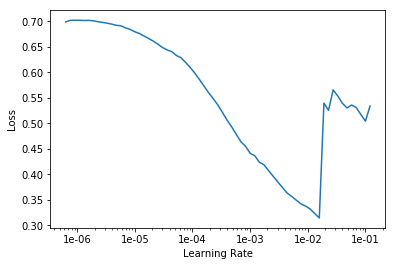

In [0]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(1, max_lr= 1e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.049062,0.051294,0.968981,2:53:27


Buffered data was truncated after reaching the output size limit.

## Predictions
Now to generate predictions. This is where you can get tripped up because the databunch does not load data in sorted order. So we'll have to do reorder the generated predictions to match their original order.

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
test_preds = get_preds_as_nparray(DatasetType.Test)

KeyboardInterrupt: ignored

In [0]:
learner.predict("I have indefinitely blocked this account")

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([0.0038, 0.0002, 0.0008, 0.0002, 0.0008, 0.0002]))

In [0]:
test['comment_text'][20]

'==Indefinitely blocked== \n I have indefinitely blocked this account.'